In [33]:
#import dependencies
from citipy import citipy
import pandas as pd
import random
from config import api_key
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#setup lists to hold our random long and lats
random_long = []
random_lat = []

#count to 500, generate a random list of longitudes and latitudes
i = 1
while i <= 500:
    random_long.append(random.randint(-180, 80))
    random_lat.append(random.randint(-90, 90))
    #per https://knowledge.domo.com/Visualize/Adding_Cards_to_Domo/KPI_Cards/Building_Each_Chart_Type/Latitude-Longitude_Map
    #longitude ranges from -180 to 80 and latitude ranges from -90 to 90
    i = i + 1

In [3]:
#empty list of cities
list_of_cities = []

#run through our random lat and longs, find the closest city via citipy
j = 0
while j <= 499:
    city = citipy.nearest_city(random_lat[j],random_long[j])
    list_of_cities.append(str(city.city_name))
    j = j + 1

In [15]:
#openweath URL and the parameters
url = "http://api.openweathermap.org/data/2.5/weather?"
query_url = f"{url}appid={api_key}&units=imperial&q="

#blank lists to hold the data
list_of_long = []
list_of_lat = []
list_of_temp = []
list_of_humid = []
list_of_cloudy = []
list_of_wind = []

#count to 500, pull the results, save to lists
k = 0
while k <= 499:
    response = requests.get(query_url + list_of_cities[k]).json()
    try:
        list_of_long.append(response['coord']['lon'])
        list_of_lat.append(response['coord']['lat'])
        list_of_temp.append(response['main']['temp'])
        list_of_humid.append(response['main']['humidity'])
        list_of_cloudy.append(response['clouds']['all'])
        list_of_wind.append(response['wind']['speed'])
        k = k + 1
    #error capture, if openweather can't find the city name, delete the city name from the list and generate a new random long/lat and get a new city name
    except KeyError:
        city_to_delete = list_of_cities[k]
        list_of_cities.remove(city_to_delete)
        new_long = random.randint(-180, 80)
        new_lat = random.randint(-90, 90)
        new_city = citipy.nearest_city(new_lat,new_long)
        list_of_cities.append(str(new_city.city_name))

Text(0.5, 0, 'Latitude')

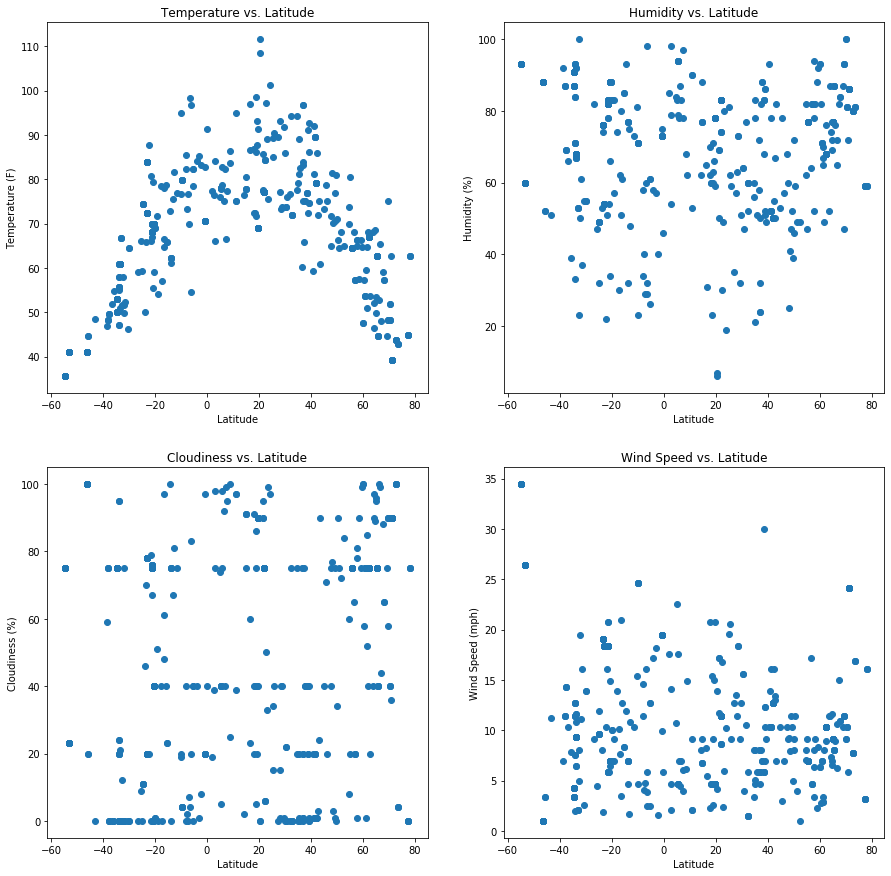

In [21]:
#create scatter plots
fig, axs = plt.subplots(2, 2, figsize=(15,15))

axs[0, 0].scatter(list_of_lat, list_of_temp)
axs[0, 0].set_title('Temperature vs. Latitude')
axs[0, 0].set_ylabel('Temperature (F)')
axs[0, 0].set_xlabel('Latitude')
#There are highest temperatures near the equator, and then decrease as you approach the pole

axs[0, 1].scatter(list_of_lat, list_of_humid)
axs[0, 1].set_title('Humidity vs. Latitude')
axs[0, 1].set_ylabel('Humidity (%)')
axs[0, 1].set_xlabel('Latitude')
#no correlation between humidity and latitude, probably dependant on other things like climate, local topgraphy and elevation, etc.

axs[1, 0].scatter(list_of_lat, list_of_cloudy)
axs[1, 0].set_title('Cloudiness vs. Latitude')
axs[1, 0].set_ylabel('Cloudiness (%)')
axs[1, 0].set_xlabel('Latitude')
#hard to find a correlation between cloudiness and latitude. OpenWeather must have preset cloudiness percentages which is why many are plotting to lines ("mostly cloudy" returns a value of 75%, "partly cloudy" returns a value of 50%)

axs[1, 1].scatter(list_of_lat, list_of_wind)
axs[1, 1].set_title('Wind Speed vs. Latitude')
axs[1, 1].set_ylabel('Wind Speed (mph)')
axs[1, 1].set_xlabel('Latitude')
#looks like a random scattering of wind speed across latitude, some examples of extreme high wind at very low latitudes.

In [34]:
#create a blank dataframe with columns
cities_df = pd.DataFrame()
cities_df["City"] = list_of_cities
cities_df["Longitude"] = list_of_long
cities_df["Latitude"] = list_of_lat
cities_df["Temperature (F)"] = list_of_temp
cities_df["Humidity (%)"] = list_of_humid
cities_df["Cloudiness (%)"] = list_of_cloudy
cities_df["Wind Speed (mph)"] = list_of_wind

cities_df = cities_df.sort_values("Latitude")

is_northern_hemisphere = cities_df["Latitude"] >= 0
is_southern_hemisphere = cities_df["Latitude"] <= 0

cities_df_north = cities_df[is_northern_hemisphere]
cities_df_south = cities_df[is_southern_hemisphere]

list_of_lat_n = cities_df_north["Latitude"].tolist()
list_of_temp_n = cities_df_north["Temperature (F)"].tolist()
list_of_humid_n = cities_df_north["Humidity (%)"].tolist()
list_of_cloudy_n = cities_df_north["Cloudiness (%)"].tolist()
list_of_wind_n = cities_df_north["Wind Speed (mph)"].tolist()

list_of_lat_s = cities_df_south["Latitude"].tolist()
list_of_temp_s = cities_df_south["Temperature (F)"].tolist()
list_of_humid_s = cities_df_south["Humidity (%)"].tolist()
list_of_cloudy_s = cities_df_south["Cloudiness (%)"].tolist()
list_of_wind_s = cities_df_south["Wind Speed (mph)"].tolist()

#create scatter plots
#fig2, axs2 = plt.subplots(4, 2, figsize=(17,17))

# axs[0, 0].scatter(list_of_lat, list_of_temp)
# axs[0, 0].set_title('Temperature vs. Latitude')
# axs[0, 0].set_ylabel('Temperature (F)')
# axs[0, 0].set_xlabel('Latitude')
# #There are highest temperatures near the equator, and then decrease as you approach the pole

# axs[0, 1].scatter(list_of_lat, list_of_humid)
# axs[0, 1].set_title('Humidity vs. Latitude')
# axs[0, 1].set_ylabel('Humidity (%)')
# axs[0, 1].set_xlabel('Latitude')
# #no correlation between humidity and latitude, probably dependant on other things like climate, local topgraphy and elevation, etc.

# axs[1, 0].scatter(list_of_lat, list_of_cloudy)
# axs[1, 0].set_title('Cloudiness vs. Latitude')
# axs[1, 0].set_ylabel('Cloudiness (%)')
# axs[1, 0].set_xlabel('Latitude')
# #hard to find a correlation between cloudiness and latitude. OpenWeather must have preset cloudiness percentages which is why many are plotting to lines ("mostly cloudy" returns a value of 75%, "partly cloudy" returns a value of 50%)

# axs[1, 1].scatter(list_of_lat, list_of_wind)
# axs[1, 1].set_title('Wind Speed vs. Latitude')
# axs[1, 1].set_ylabel('Wind Speed (mph)')
# axs[1, 1].set_xlabel('Latitude')
# #looks like a random scattering of wind speed across latitude, some examples of extreme high wind at very low latitudes.